In [6]:
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import os
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
from matplotlib import cm
import texttable
from xclim import ensembles
import global_land_mask
import logging
from CMIP6_ridgeplot import CMIP6_ridgeplot
import CMIP6_area_calculations
import matplotlib.dates as mdates
import pyproj
pyproj.datadir.set_data_dir('/Users/trondkr/anaconda3/envs/gcs2/share/proj')
pyproj.datadir.get_data_dir()

logging.getLogger('xclim').setLevel('ERROR')
logging.getLogger('root').setLevel('ERROR')
sns.set(font_scale=1.5, style="whitegrid")

In [7]:
def convert_to_180(ds):
 #   ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)
    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)
    #  mask_data[np.isnan(mask_data)] = np.nan

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])

def resample_to_monthly(ds:xr.Dataset, var_name):
    ds = xr.where(((ds < 1.e-20) | (ds > 1e20)), np.nan, ds)
    if var_name=="tos_mean":
        ds=ds.assign(lon=ds.lon[0,:].values)
        ds=ds.assign(lat=ds.lat[:,0].values)
        ds=ds.rename({"x":"lon","y":"lat"})

    ds = convert_to_180(ds)
   # ds = ds.sel(time=slice(start_time,end_time))
    ds_lme = convert_time(ds)
    # Add land mask
    ds_lme["mask"] = create_land_ocean_mask(ds_lme)

    ds_lme = ds_lme.where(ds_lme.mask == 1)
    # Input data contains 4 timesteps per mid-day of each month.
    ds_lme = ds_lme.resample(time="M").mean()

  #  ds_lme = ds_lme.resample(time="1W").reduce(np.mean)
   # ds_lme = get_data_within_LME(ds_lme, LME)
    return ds_lme

def get_area_averaged_ds(fname_perc, fname_stats, fname_tos, scenario, var_name, LME):

    var_name_mean = f"{var_name}_min"
    var_name_std = f"{var_name}_stdev"
    var_name_tos = f"tos_mean"

    if os.path.exists(fname_stats) and os.path.exists(fname_perc) and os.path.exists(fname_tos):
        ds_perc = xr.open_dataset(fname_perc).isel(percentiles=0)
        ds_tos = xr.open_dataset(fname_tos)

      # ds_perc = ds_perc.sel(time=ds_perc.time.dt.hour == 12)

        ds_perc = resample_to_monthly(ds_perc, var_name)
        ds_perc = get_data_within_LME(ds_perc, LME)

        ds_tos = resample_to_monthly(ds_tos, var_name_tos)
        ds_tos = get_data_within_LME(ds_tos, LME)


        fname=f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/cmip6-albedo/Months_per_year_with_minimum_light_{LME}_{scenario}.nc"
        fname_tos=f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/cmip6-albedo/Months_per_year_with_minimum_light_tos_{LME}_{scenario}.nc"
        if os.path.exists(fname): os.remove(fname)
        if os.path.exists(fname_tos): os.remove(fname_tos)
        print("Saving number of months per year where  on average min light is reached")
        ds_perc.to_netcdf(fname)
        ds_tos.to_netcdf(fname_tos)

In [8]:
def get_LME_records():
    lme_file='/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_data_within_LME(ds,LME):
   # print("Working on LME: {}".format(LME))

    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.
    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function
    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'})

    return clipped

In [9]:
scenarios = ["ssp245", "ssp585"]
member_range = 12

period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

models = ["ensemble"]
ds_var_names = ["par"]

write_stats_to_file = False
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
#LMES = ['Barents Sea']

for var_name in ds_var_names:
    for LME in LMES:
        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:

            fname_perc = f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/oceanography/light/ncfiles/ensemble/{var_name}_ensemble_perc_{scenario}.nc"
            fname_stats = f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/oceanography/light/ncfiles/ensemble/{var_name}_ensemble_stats_{scenario}.nc"
            fname_tos = f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/oceanography/light/ncfiles/ensemble/tos_ensemble_{scenario}.nc"

            if scenario=="ssp585":
                label="SSP5-8.5"
            else:
                label="SSP2-4.5"

            get_area_averaged_ds(fname_perc, fname_stats, fname_tos, scenario, var_name, LME)


[create_land_ocean_mask] Running create_land_ocean_mask
[create_land_ocean_mask] Running create_land_ocean_mask
Saving number of months per year where  on average min light is reached
[create_land_ocean_mask] Running create_land_ocean_mask
[create_land_ocean_mask] Running create_land_ocean_mask
Saving number of months per year where  on average min light is reached
[create_land_ocean_mask] Running create_land_ocean_mask
[create_land_ocean_mask] Running create_land_ocean_mask
Saving number of months per year where  on average min light is reached
[create_land_ocean_mask] Running create_land_ocean_mask
[create_land_ocean_mask] Running create_land_ocean_mask
Saving number of months per year where  on average min light is reached


winter_spring - ssp245: change tos (1980-2000 vs 2090-2100): spatial_ref    0.000000
tos_mean       3.131503
dtype: float64 months
winter_spring - ssp245: change par (1980-2000 vs 2090-2100): par    1.882225
dtype: float64 months
winter_spring - ssp585: change tos (1980-2000 vs 2090-2100): spatial_ref    0.000000
tos_mean       3.577962
dtype: float64 months
winter_spring - ssp585: change par (1980-2000 vs 2090-2100): par    2.372977
dtype: float64 months
Saving to file Figures/Timeseries_months_per_year_with_minimum_tos_and_par_Barents Sea_winter_spring.png
winter_spring - ssp245: change tos (1980-2000 vs 2090-2100): spatial_ref    0.000000
tos_mean       0.861618
dtype: float64 months
winter_spring - ssp245: change par (1980-2000 vs 2090-2100): par    1.487941
dtype: float64 months
winter_spring - ssp585: change tos (1980-2000 vs 2090-2100): spatial_ref    0.000000
tos_mean       4.019412
dtype: float64 months
winter_spring - ssp585: change par (1980-2000 vs 2090-2100): par    2.3585

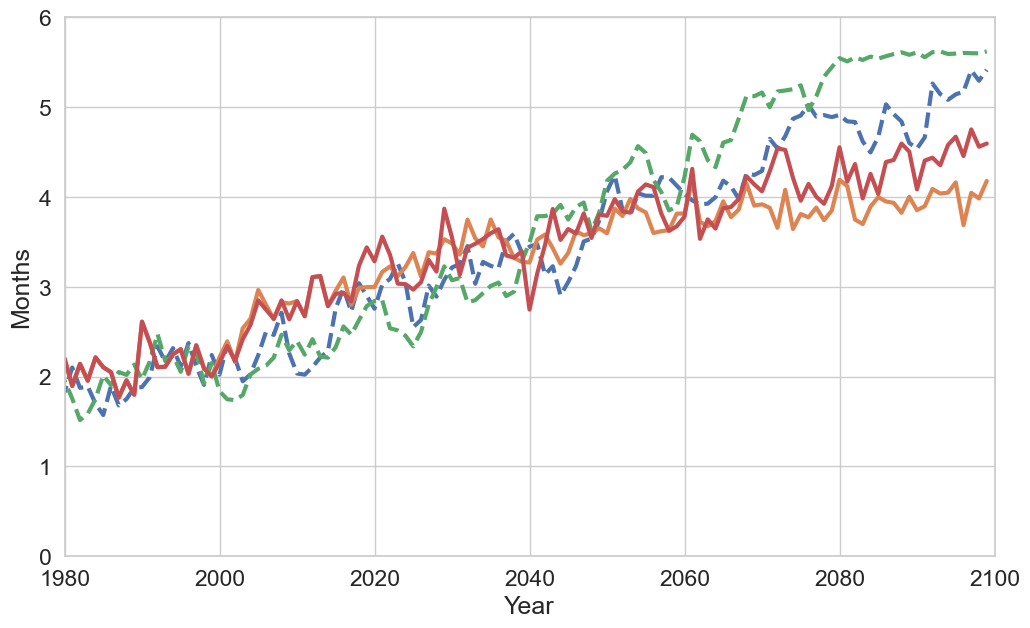

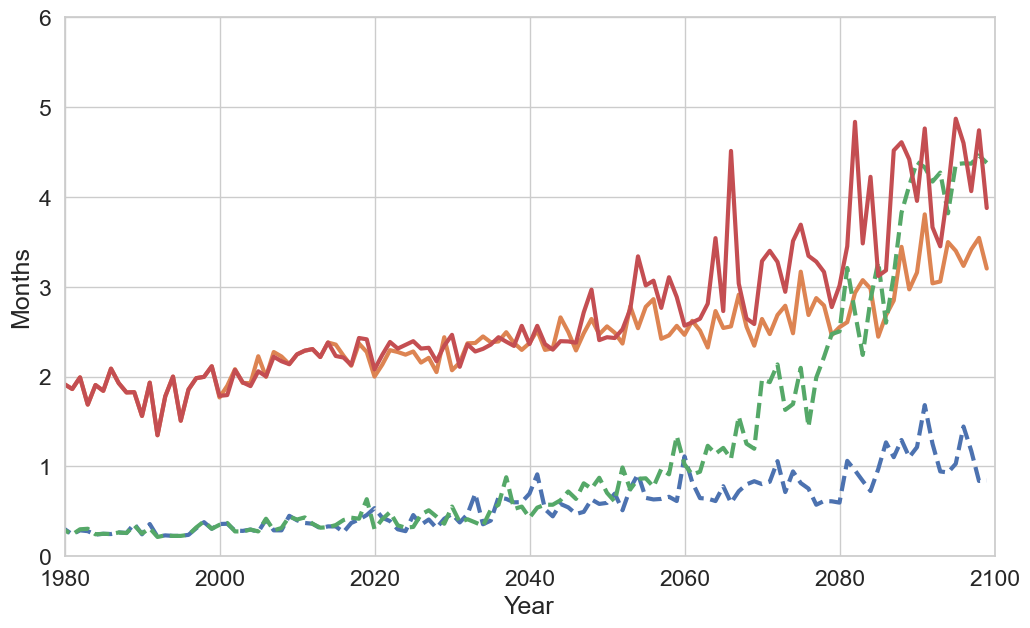

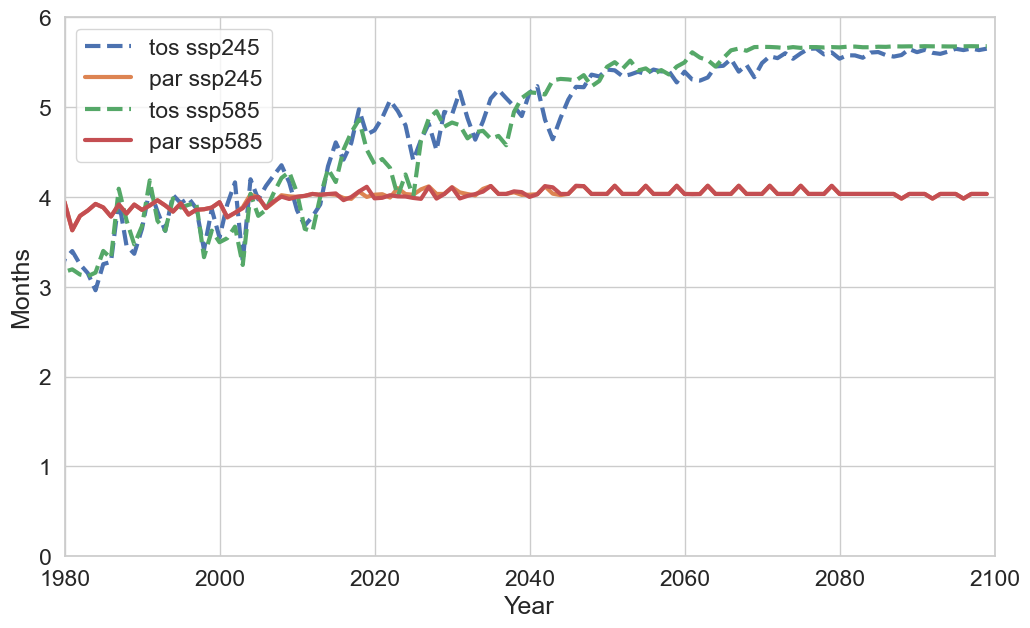

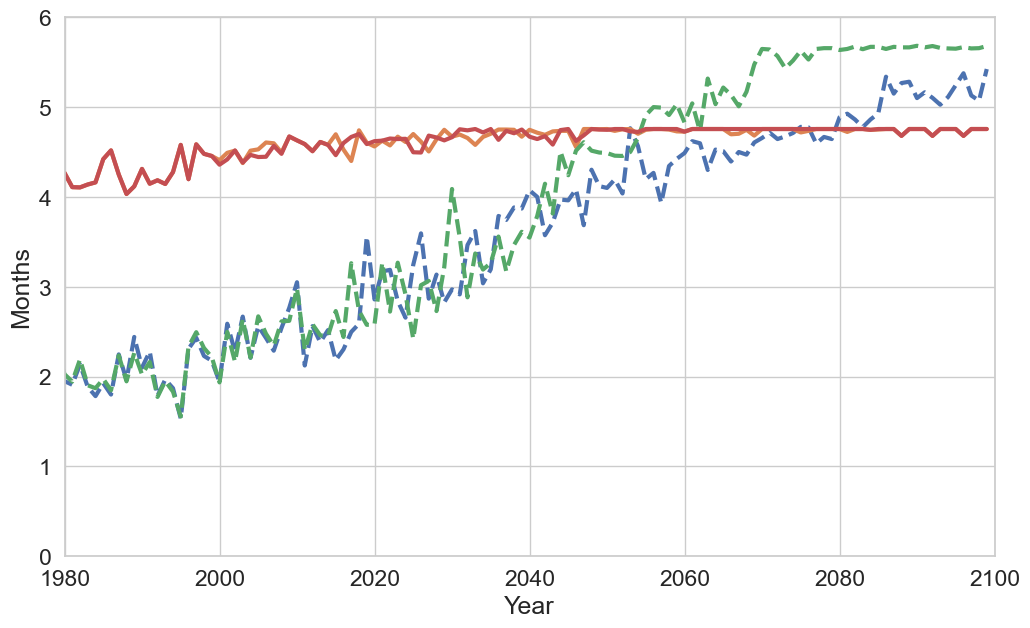

In [10]:
import datetime

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
scenarios = ["ssp245", "ssp585"]

#LMES = ['Northern Bering - Chukchi Seas']
#scenarios = ["ssp245"]
light_threshold=0.1 #e-4
for season in ["winter_spring", "summer_fall"]:
    for LME in LMES:
        ax_time=None
        timeseries=True
        for scenario in scenarios:
            ds = xr.open_dataset(f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/cmip6-albedo/Months_per_year_with_minimum_light_{LME}_{scenario}.nc")
            ds_tos = xr.open_dataset(f"/Users/trondkr/Library/CloudStorage/Dropbox/NIVA/cmip6-albedo/Months_per_year_with_minimum_light_tos_{LME}_{scenario}.nc")

            ds_fix = xr.where(ds["par"]>light_threshold,1, 0)
            ds_fix = xr.where(ds_fix<-1,np.nan,ds_fix)

            ds_fix_tos = xr.where(ds_tos["tos_mean"]>0.0, 1, 0).sel(time=slice("1979","2100"))
            ds_fix_tos = xr.where(ds_fix_tos<-2,np.nan,ds_fix_tos)

            def is_summer_fall(month):
                return (month >= 7) & (month <= 12 )
            def is_winter_spring(month):
                return (month >= 1) & (month <= 6 )
            if season == "summer_fall":
                ds_fix = ds_fix.sel(time=is_summer_fall(ds_fix['time.month']))
            elif season == "winter_spring":
                ds_fix = ds_fix.sel(time=is_winter_spring(ds_fix['time.month']))

            light_count = ds_fix  \
                    .groupby('time.year') \
                    .sum(dim='time')
            light_count = get_data_within_LME(light_count, LME)

            if season == "summer_fall":
                ds_fix_tos = ds_fix_tos.sel(time=is_summer_fall(ds_fix_tos['time.month']))
            elif season == "winter_spring":
                ds_fix_tos = ds_fix_tos.sel(time=is_winter_spring(ds_fix_tos['time.month']))

            tos_count = ds_fix_tos \
                    .groupby('time.year') \
                    .sum(dim='time')
            tos_count = get_data_within_LME(tos_count, LME)

            ds=light_count.mean({"lat","lon"}, skipna=True)
        
            df=ds.to_dataframe()

            df["year"]=df.index

        # df = df.pivot('year','percentiles', 'par')
            df=df.drop(columns=['percentiles','year','spatial_ref'])

            if not timeseries:
                fig=plt.figure(figsize=(12,7))
                ax = sns.heatmap(df, annot = False)
                ax.invert_yaxis()
                ax.set(xlabel="Months of the year when minimum light is above 1Wm$^{2}$")

                plotfile=f"Figures/Months_per_year_with_minimum_tos_{LME}_{scenario}.png"
                if os.path.exists(plotfile): os.remove(plotfile)
                plt.savefig(plotfile)
            #  plt.show()

            ds=tos_count.mean({"lat","lon"}, skipna=True)

            df_tos=ds.to_dataframe()
            if not timeseries:
                fig=plt.figure(figsize=(12,7))

                df_tos["year"]=df_tos.index
                df_tos=df_tos.drop(columns=['spatial_ref','year'])

            #  df_tos = df_tos.pivot('year','spatial_ref','tos_mean')

                ax = sns.heatmap(df_tos, annot = False)
                ax.invert_yaxis()
                ax.set(xlabel="Months of the year when minimum temp is above 0$^{o}$C")

                plotfile=f"Figures/Months_per_year_with_minimum_tos_{LME}_{scenario}.png"
                if os.path.exists(plotfile): os.remove(plotfile)
                plt.savefig(plotfile)

            # Timeseries
            if timeseries:
                sns.set_style("whitegrid", {'legend.frameon':False})

                if ax_time is None:
                    fig=plt.figure(figsize=(12,7))
                    ax_time = sns.lineplot(x = "year", y = "tos_mean", data = df_tos, linewidth=3, label=f"tos {scenario}", linestyle='--')
                else:
                    sns.lineplot(ax=ax_time, x = "year", y = "tos_mean", data = df_tos, linewidth=3, label=f"tos {scenario}", linestyle='--')
                sns.lineplot(ax=ax_time, x = "year", y = "par", data = df, linewidth=3, label=f"par {scenario}")

                # Calculate some statistics for use in paper
                start = df.index.searchsorted(1980)
                end = df.index.searchsorted(2000)

                start_proj = df.index.searchsorted(2090)
                end_proj = df.index.searchsorted(2100)

                change_tos = df_tos.iloc[start_proj:end_proj].mean() - df_tos.iloc[start:end].mean()
                change_par = df.iloc[start_proj:end_proj].mean() - df.iloc[start:end].mean()

                print(f"{season} - {scenario}: change tos (1980-2000 vs 2090-2100): {change_tos} months")
                print(f"{season} - {scenario}: change par (1980-2000 vs 2090-2100): {change_par} months")
                # end stats

                if scenario=="ssp585":
                    ax_time.set(xlabel="Year")
                    ax_time.set(ylabel="Months")
                    ax_time.set_ylim(0, 6)
                    ax_time.set_xlim(1980, 2100)
                    if season == "summer_fall" and LME==LMES[0]:
                        ax_time.legend(loc='upper left')
                    else:
                        ax_time.get_legend().remove()
                    plotfile=f"Figures/Timeseries_months_per_year_with_minimum_tos_and_par_{LME}_{season}.png"
                    if os.path.exists(plotfile): os.remove(plotfile)
                    print(f"Saving to file {plotfile}")
                    fig.savefig(plotfile,dpi=300)
                #  plt.show()
